## About dataset

- Ticker: El símbolo de ticker de la acción. Cada acción cotizada en el mercado tiene un símbolo único que la identifica. Por ejemplo, AAPL para Apple Inc. o GOOGL para Alphabet Inc.

- Date: La fecha específica de negociación. Es la fecha en la que se registraron los precios de las acciones.

- Open: El precio de apertura de la acción para el día. Es el precio al que se inició la negociación de la acción al comienzo del día de negociación.

- High: El punto de precio más alto de la acción durante el día. Representa el precio más alto al que la acción ha llegado durante el día de negociación.

- Low: El punto de precio más bajo de la acción durante el día. Representa el precio más bajo al que la acción ha llegado durante el día de negociación.

- Close: El precio de cierre de la acción. Es el precio al que la acción se negoció al final del día de negociación.

- Adj Close: El precio de cierre ajustado. A veces, los precios de cierre se ajustan para tener en cuenta eventos corporativos como divisiones de acciones o dividendos. El precio de cierre ajustado refleja estos ajustes.

- Volume: El volumen total de negociación de la acción durante el día. Representa la cantidad total de acciones que se han negociado durante el día de negociación.

# Analysis of the Trends

## Import Libraris

In [1]:
# Data
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Visual
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ML
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error,make_scorer,r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor,ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from joblib import dump


## Load Data

In [2]:
df = pd.read_csv("/kaggle/input/stock-market-analysis/stocks.csv")
df.head()

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
1,AAPL,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100
2,AAPL,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100
3,AAPL,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57450700
4,AAPL,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.850006,62199000


In [3]:
def get_info_df(df):
    # Información básica sobre el DataFrame
    df_info = pd.DataFrame({'Column': df.columns,
                            'No_Nulls': df.notnull().sum().values,
                            'No_Unique': df.nunique().values,
                            'Type': df.dtypes.values},
                           index=range(1, len(df.columns)+1))
    
    return df_info
get_info_df(df)

,Column,No_Nulls,No_Unique,Type
1,Ticker,248,4,object
2,Date,248,62,object
3,Open,248,244,float64
4,High,248,248,float64
5,Low,248,248,float64
6,Close,248,244,float64
7,Adj Close,248,244,float64
8,Volume,248,248,int64


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02
mean,215.252093,217.919662,212.697452,215.381674,215.362697,3.208210e+07
std,91.691315,92.863023,90.147881,91.461989,91.454750,2.233590e+07
min,89.540001,90.129997,88.860001,89.349998,89.349998,2.657900e+06
25%,135.235004,137.440004,134.822495,136.347498,136.347498,1.714180e+07
50%,208.764999,212.614998,208.184998,209.920006,209.920006,2.734000e+07
75%,304.177505,307.565002,295.437500,303.942505,303.942505,4.771772e+07
max,372.410004,373.829987,361.739990,366.829987,366.829987,1.133164e+08


In [5]:
df.Ticker.value_counts()

Ticker
AAPL    62
MSFT    62
NFLX    62
GOOG    62
Name: count, dtype: int64

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

## Time Series Analysis¶

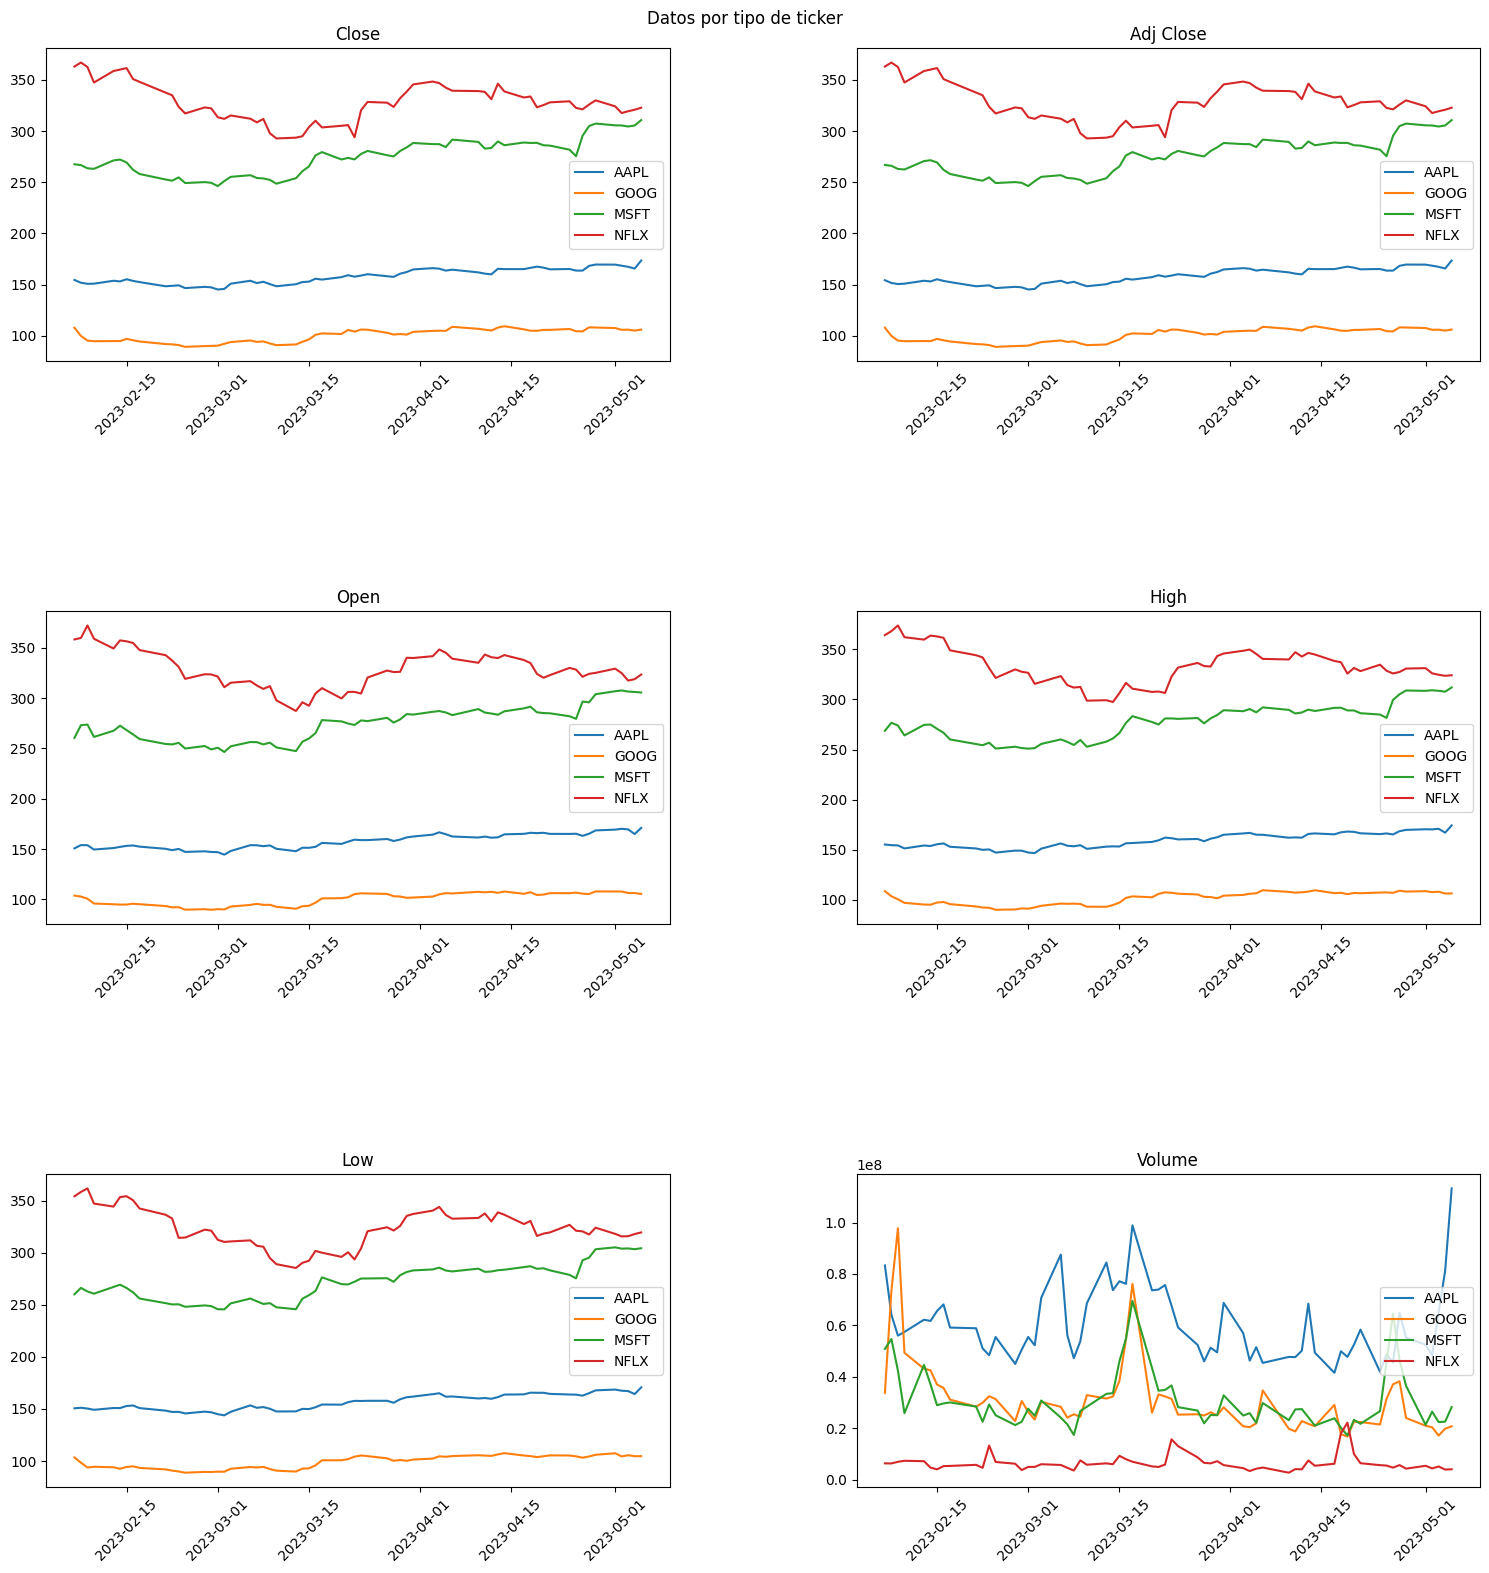

In [7]:
fig, axs = plt.subplots(3, 2, figsize=(15, 16))
fig.suptitle('Datos por tipo de ticker')
cols = ['Close', 'Adj Close','Open', 'High', 'Low', 'Volume']
for i,col in enumerate(cols):
    row = i // 2
    col = i % 2
    for ticker, data in df.groupby('Ticker'):
        axs[row, col].plot(data['Date'], data[cols[i]], label=ticker)
    axs[row, col].set_title(cols[i])
    axs[row, col].legend(loc='right')
    axs[row, col].tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.8)
plt.show()

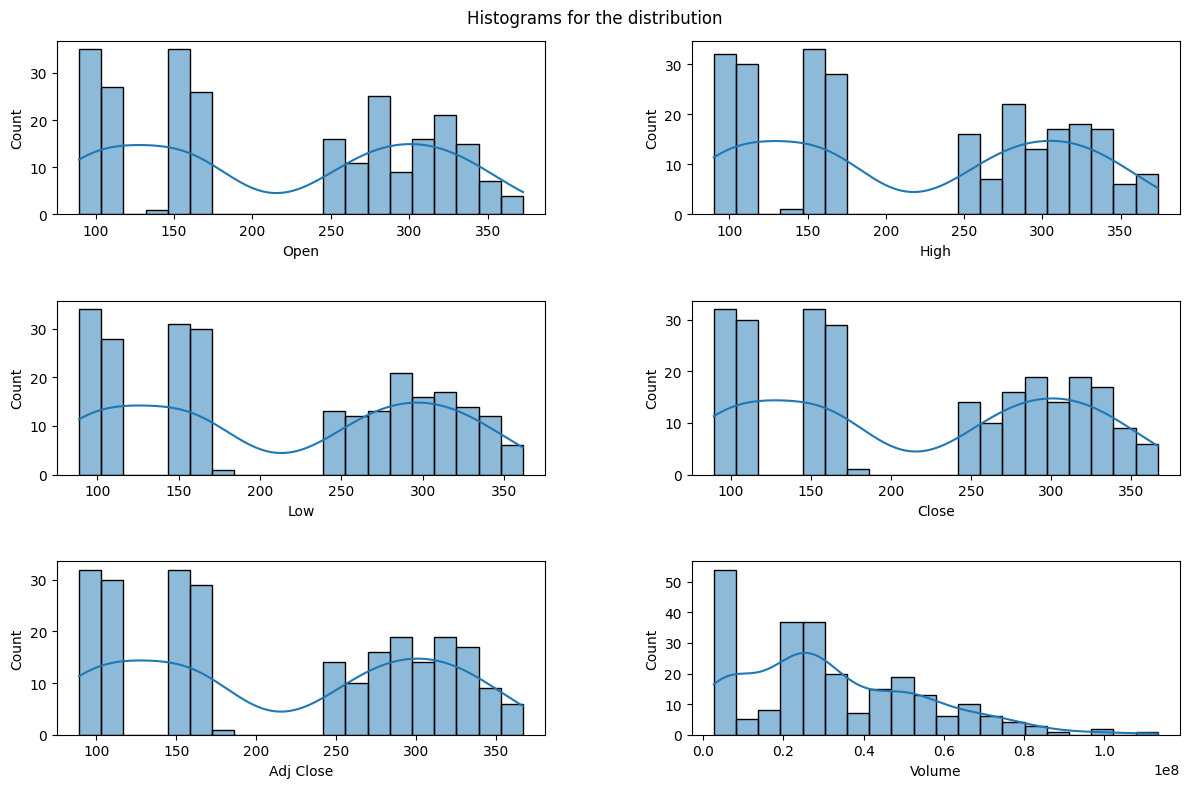

In [8]:
cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
fig.suptitle('Histograms for the distribution')

for i in range(len(cols)):
    row = i // 2
    col = i % 2
    sns.histplot(df[cols[i]], bins=20, kde=True, ax=axs[row, col])

plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [9]:
# Group by close for the metrics in posteriory
grouped_ticker_close = df.pivot_table(index='Date', columns='Ticker', values='Close')

## Evaluación de la Volatilidad

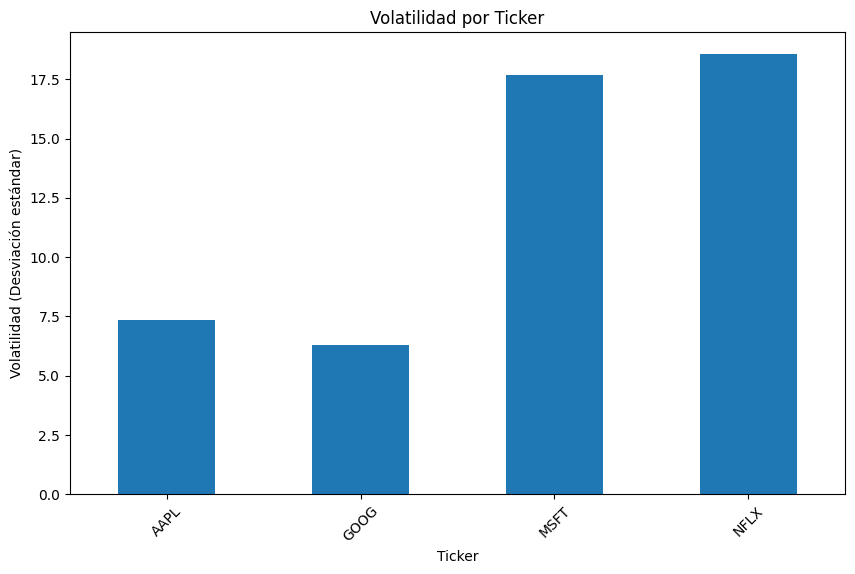

In [10]:
volatility = grouped_ticker_close.std()

plt.figure(figsize=(10, 6))
volatility.plot(kind='bar')
plt.title('Volatilidad por Ticker')
plt.xlabel('Ticker')
plt.ylabel('Volatilidad (Desviación estándar)')
plt.xticks(rotation=45)
plt.show()

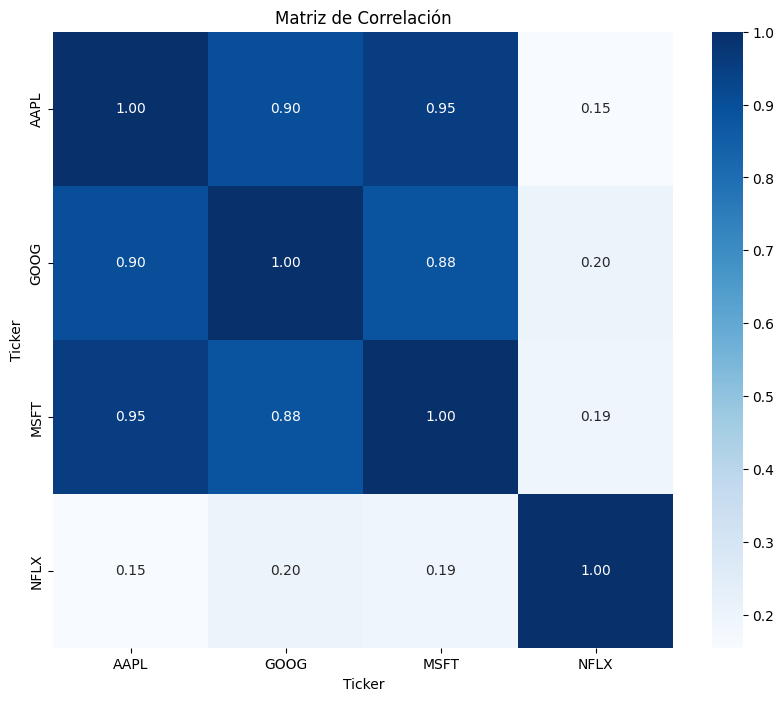

In [11]:
correlation_matrix = grouped_ticker_close.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

In [12]:
grouped_ticker_close.corr()

Ticker,AAPL,GOOG,MSFT,NFLX
Ticker,,,,
AAPL,1.000000,0.901662,0.953037,0.154418
GOOG,0.901662,1.000000,0.884527,0.201046
MSFT,0.953037,0.884527,1.000000,0.191273
NFLX,0.154418,0.201046,0.191273,1.000000


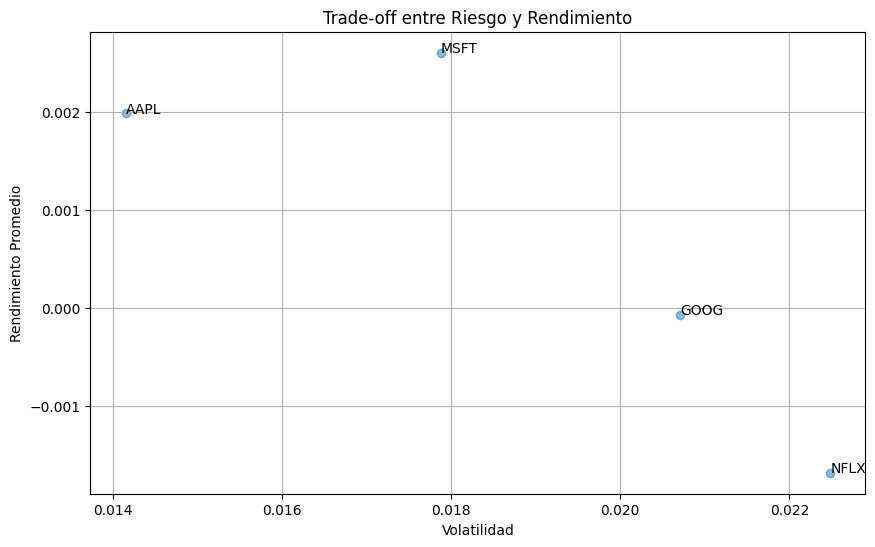

In [13]:
df['Daily Return'] = df.groupby('Ticker')['Close'].pct_change()

volatility = df.groupby('Ticker')['Daily Return'].std()

risk_return_df = pd.DataFrame({'Volatility': volatility,
                               'Average Return': df.groupby('Ticker')['Daily Return'].mean()})

# Grafica el trade-off entre riesgo y rendimiento
plt.figure(figsize=(10, 6))
plt.scatter(risk_return_df['Volatility'], risk_return_df['Average Return'], alpha=0.5)

# Etiqueta cada punto con el nombre del ticker
for ticker, row in risk_return_df.iterrows():
    plt.text(row['Volatility'], row['Average Return'], ticker)

plt.title('Trade-off entre Riesgo y Rendimiento')
plt.xlabel('Volatilidad')
plt.ylabel('Rendimiento Promedio')
plt.grid(True)
plt.show()